In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [2]:
import deepxde as dde 
import torch 
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
rho = 1 
mu = 1 
u_in = 1
D = 1 
L = 2

In [4]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)

    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)

    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    u = Y[:, 0:1]
    v = Y[:, 1:2]

    pde_u = u*du_x + v*du_y + (1/rho)*dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = u*dv_x + v*dv_y + (1/rho)*dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_con = du_x + dv_y 

    return [pde_u, pde_v, pde_con]

In [5]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(on_boundary, np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)))
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [6]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0, boundary_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0, boundary_outlet, component=1)

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain=3000,
                    num_boundary=500,
                    num_test=1000,
                    train_distribution='LHS')

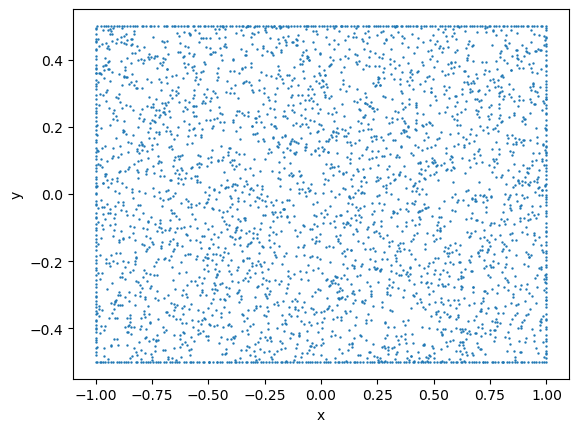

In [8]:
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
layer_size = [2] + [64] * 5 + [3]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [10]:
model = dde.Model(data, net)

In [11]:
model.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.500079 s



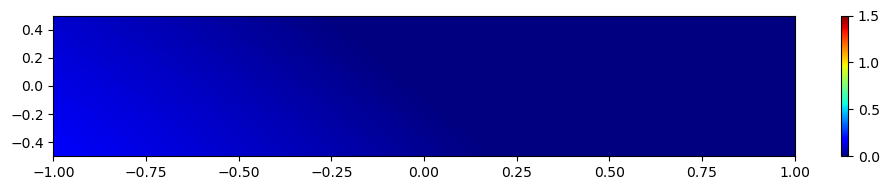

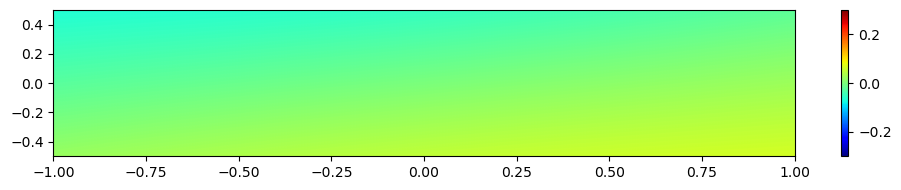

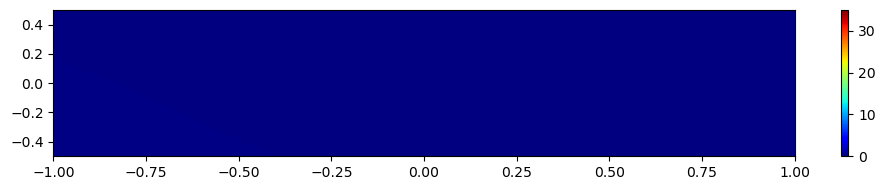

In [12]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(10, 2))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.81e-02, 2.07e-02, 5.27e-02, 7.34e-03, 2.44e-03, 7.48e-01, 1.21e-03, 2.82e-02, 1.21e-03]    [2.84e-02, 2.08e-02, 5.41e-02, 7.34e-03, 2.44e-03, 7.48e-01, 1.21e-03, 2.82e-02, 1.21e-03]    []  
1000      [7.63e-03, 1.07e-03, 8.32e-03, 3.21e-02, 1.46e-02, 3.86e-02, 1.64e-03, 3.06e-03, 3.21e-05]    [6.90e-03, 7.26e-04, 5.55e-03, 3.21e-02, 1.46e-02, 3.86e-02, 1.64e-03, 3.06e-03, 3.21e-05]    []  
2000      [1.67e-03, 7.03e-04, 4.08e-03, 2.49e-02, 1.19e-02, 2.88e-02, 1.51e-03, 2.26e-04, 3.28e-05]    [1.41e-03, 5.39e-04, 2.86e-03, 2.49e-02, 1.19e-02, 2.88e-02, 1.51e-03, 2.26e-04, 3.28e-05]    []  
3000      [3.80e-03, 1.65e-03, 3.32e-03, 2.12e-02, 9.63e-03, 2.33e-02, 3.35e-03, 5.84e-04, 1.67e-05]    [3.19e-03, 1.31e-03, 2.11e-03, 2.12e-02, 9.63e-03, 2.33e-0

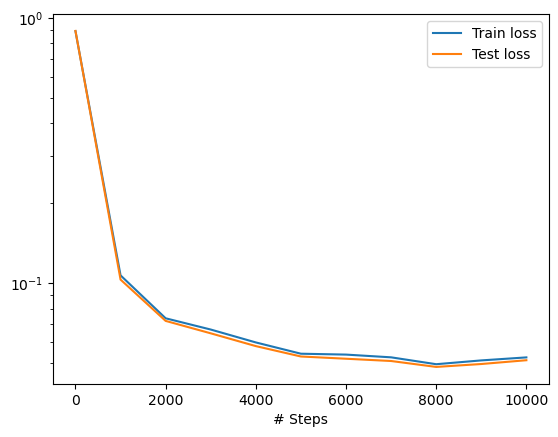

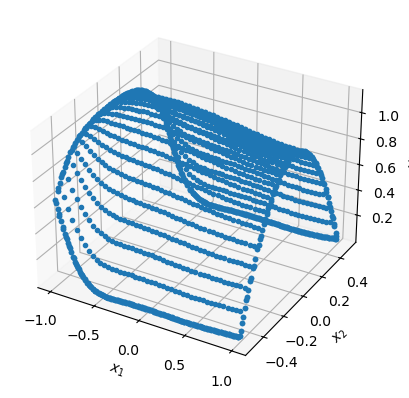

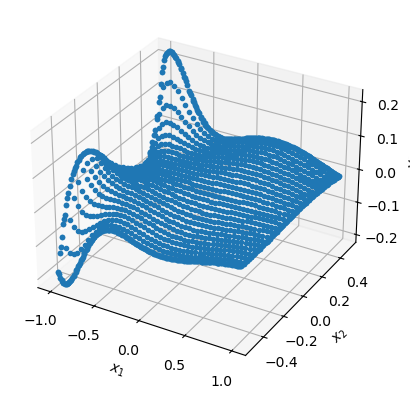

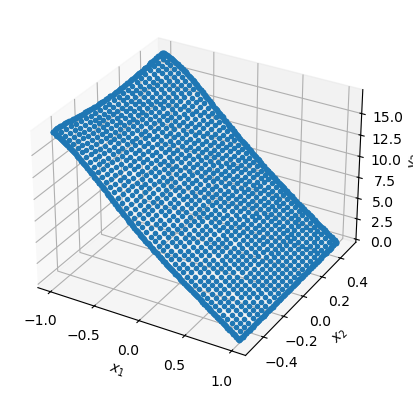

In [13]:
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

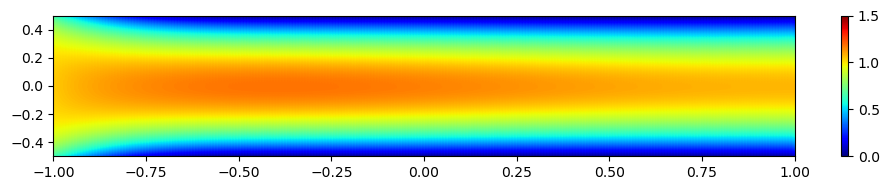

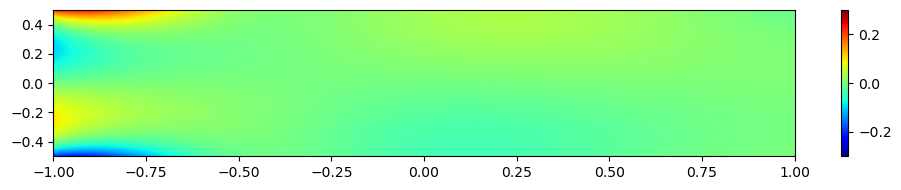

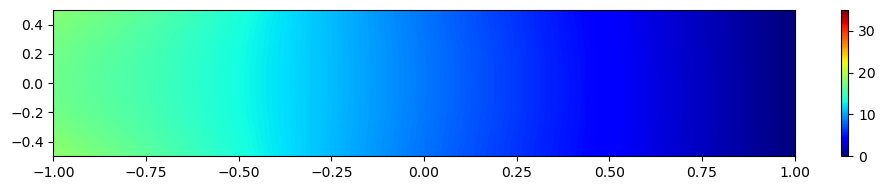

In [14]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(10, 2))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

In [15]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")

Compiling model...
'compile' took 0.001804 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [4.25e-03, 1.26e-03, 1.75e-03, 1.89e-02, 5.82e-03, 1.40e-02, 6.55e-03, 4.08e-05, 1.60e-05]    [4.15e-03, 9.43e-04, 8.96e-04, 1.89e-02, 5.82e-03, 1.40e-02, 6.55e-03, 4.08e-05, 1.60e-05]    []  
11000     [7.68e-04, 9.22e-04, 1.28e-03, 1.19e-02, 1.47e-03, 6.88e-03, 3.28e-03, 4.58e-05, 1.15e-05]    [6.79e-04, 5.00e-04, 9.25e-04, 1.19e-02, 1.47e-03, 6.88e-03, 3.28e-03, 4.58e-05, 1.15e-05]    []  
12000     [4.86e-04, 3.38e-04, 6.58e-04, 8.46e-03, 1.22e-03, 5.37e-03, 2.64e-03, 8.61e-06, 6.70e-06]    [5.29e-04, 2.40e-04, 4.24e-04, 8.46e-03, 1.22e-03, 5.37e-03, 2.64e-03, 8.61e-06, 6.70e-06]    []  
13000     [3.75e-04, 4.23e-04, 3.03e-04, 7.40e-03, 1.25e-03, 4.07e-03, 2.16e-03, 1.03e-05, 2.07e-06]    [3.03e-04, 3.14e-04, 1.33e-04, 7.40e-03, 1.25e-03, 4.07e-0

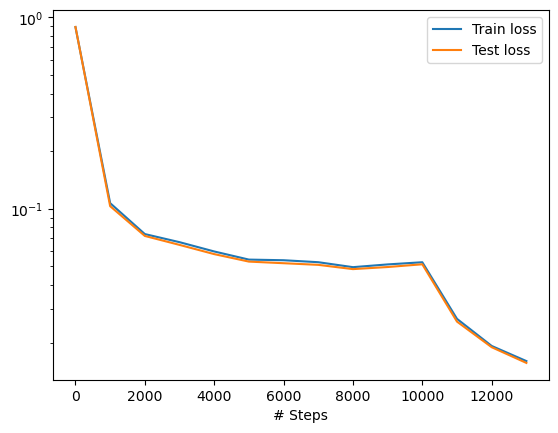

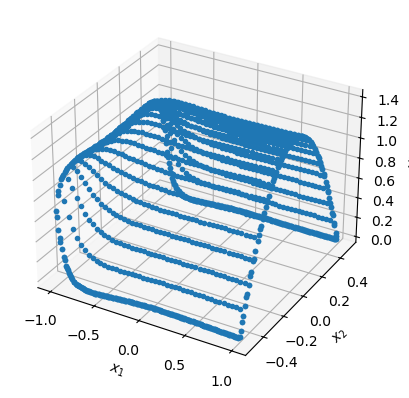

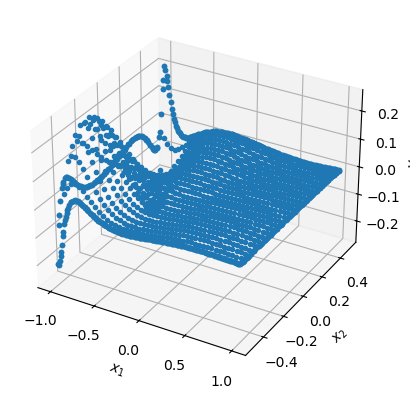

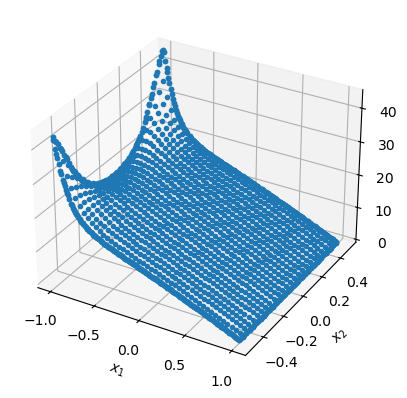

In [16]:
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

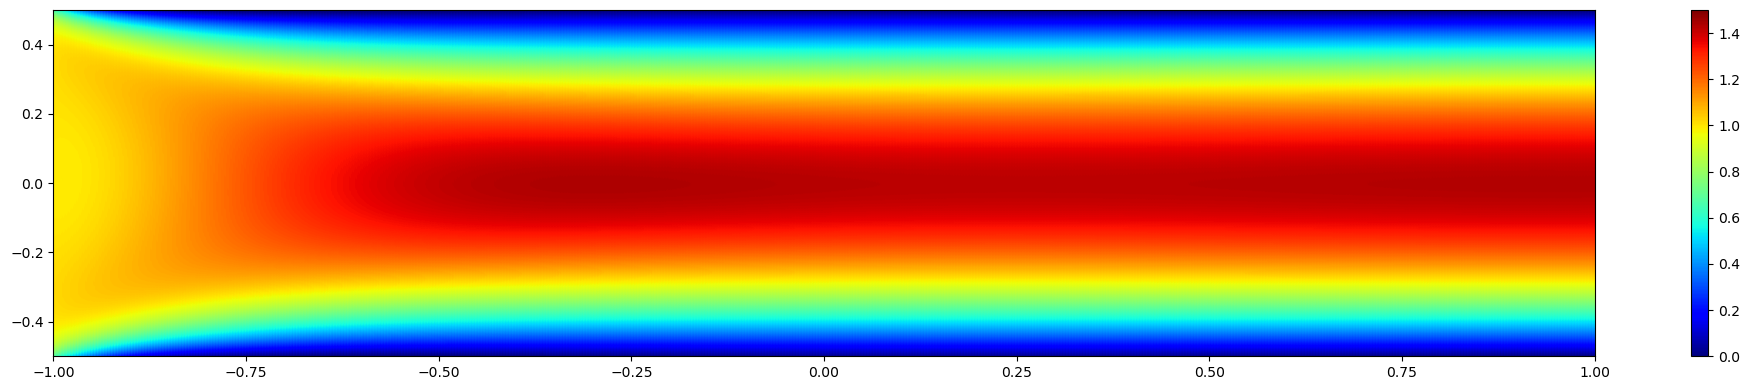

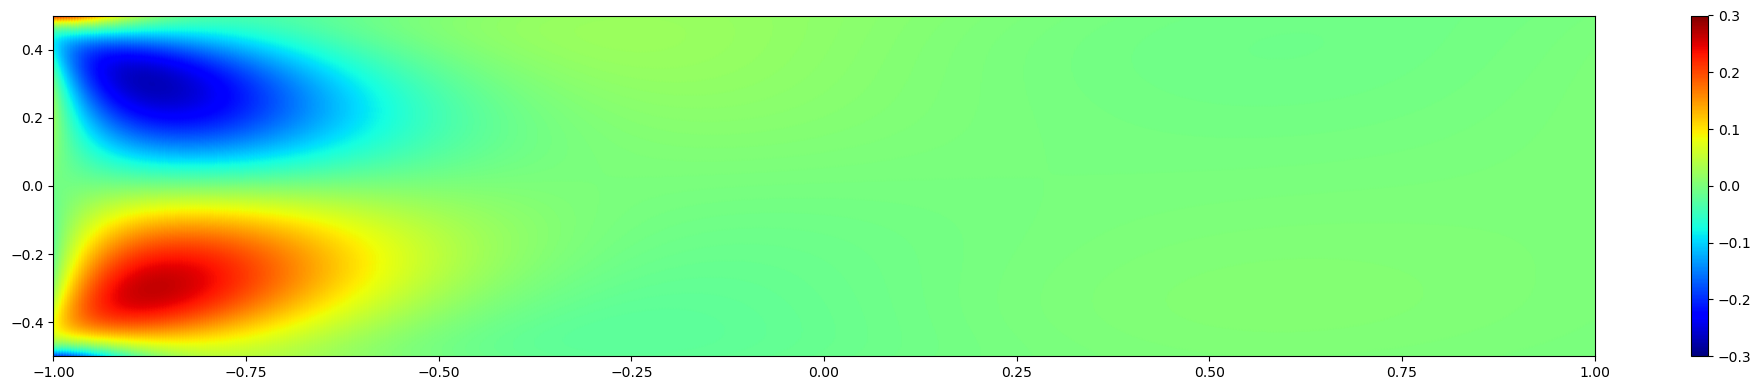

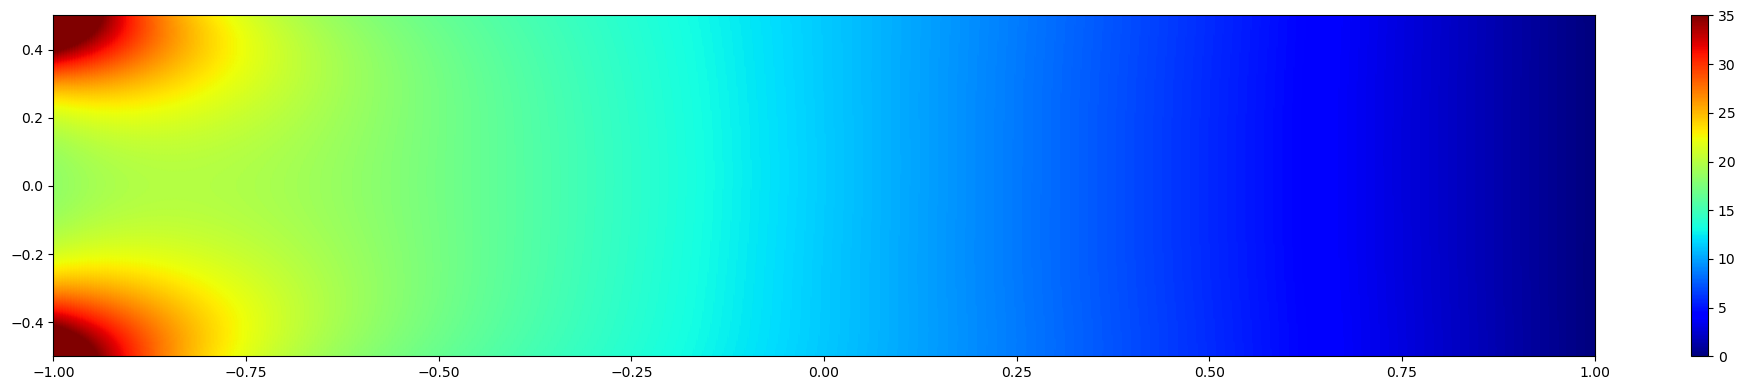

In [17]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

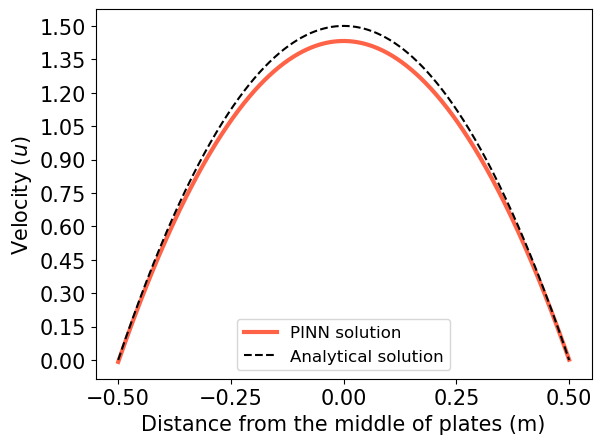

In [18]:
x = np.ones([1000, 1])
y = np.linspace(-D/2, D/2, 1000).reshape(-1, 1)
outlet = np.hstack([x, y])
u_true_outlet = 1.5 * u_in * (1 - ((y)/(D/2))**2)
pinn_solution = model.predict(outlet)
u_pred_outlet = pinn_solution[:, 0]

plt.plot(y, u_pred_outlet, c='tomato', linewidth=3, label='PINN solution')
plt.plot(y, u_true_outlet, c='k', linestyle='--', label='Analytical solution')
plt.xticks(np.linspace(-D/2, D/2, 5), fontsize=15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Distance from the middle of plates (m)', fontsize=15)
plt.ylabel('Velocity ($u$)', fontsize=15)
plt.show()